In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os

In [0]:
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

In [0]:
train_dir = '/content/gdrive/My Drive/Small/train'
test_dir =  '/content/gdrive/My Drive/Small/test'
X = []
Y = []

#Loop through the training and test folders, as well as the 'normal' and 'affected' subfolders and append all images into array X.  Append the classification (0 or 1) into array Y.

for fileName in os.listdir(train_dir + "/normal"): 
        img = cv2.imread(train_dir + "/normal/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(train_dir + "/affected"): 
        img = cv2.imread(train_dir + "/affected/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)
            
for fileName in os.listdir(test_dir + "/normal"): 
        img = cv2.imread(test_dir + "/normal/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(test_dir + "/affected"): 
        img = cv2.imread(test_dir + "/affected/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)

In [0]:
print("This is an example of a healthy patient:")
normal = cv2.imread(test_dir + "/normal/CTR_TRN_181_z244.png")
plt.axis('off')
plt.imshow(normal)

In [0]:
print("This is an example of an unhealthy patient:")
pnumonia = cv2.imread(test_dir + "/affected/CTR_TRN_174_z243.png")
plt.axis('off')
plt.imshow(pnumonia)

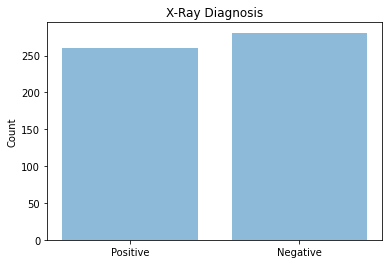

There are 260 pneumonia positive X-ray's in our data
There are 281 pneumonia negative X-ray's in our data


In [0]:
#Data visualization

pos = 0
neg = 0

for i in range(1,len(Y)):
    if Y[i] == 1:
        pos = pos + 1
    else:
        neg = neg + 1

objects = ('Positive', 'Negative')
y_pos = np.arange(len(objects))
performance = [pos,neg]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('X-Ray Diagnosis')
 
plt.show()

print("There are " +str(pos) +"  positive X-ray's in our data")
print("There are " +str(neg) +"  negative X-ray's in our data")

In [0]:
#Normalize our images to ensure gradients do not diverge
X = np.array(X)/255

#Normalize our data by setting the mean to 0 and variance to 1.
X = (X - np.average(X,0))/np.std(X,0)
#Convert our Y vector into a categorical (e.g. 0 -> (0,1), 1 -> (1,0))           
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y, num_classes = 2) #Randomly create our training and test sets using 2/3 of the data for training, and the remaining 1/3 for testing

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

pos_train =0
neg_train = 0
pos_test = 0
neg_test = 0


for i in range(1,len(Y_train)):
    if Y_train[i][0] == 1:
        pos_train = pos_train + 1
    else:
        neg_train = neg_train + 1
        
for i in range(1,len(Y_test)):
    if Y_test[i][0] == 1:
        pos_test = pos_test + 1
    else:
        neg_test = neg_test + 1
        
print("Positive in training: " + str(pos_train))
print("Negative in training: " + str(neg_train))
print("Train pos/neg ratio: " + str (pos_train/neg_train))
      
print("Positive in test: " + str(pos_test))
print("Negative in test: " + str(neg_test))
print("Test pos/neg ratio: " + str (pos_test/neg_test))

Positive in training: 185
Negative in training: 177
Train pos/neg ratio: 1.0451977401129944
Positive in test: 95
Negative in test: 83
Test pos/neg ratio: 1.144578313253012


In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    return X, Y

In [0]:
def initialize_parameters():
    W1 = tf.get_variable("W1",[3,3,3,10],initializer = tf.contrib.layers.xavier_initializer()) #Define our weight for the first convolutional layer
    W2 = tf.get_variable("W2",[5,5,10,8],initializer = tf.contrib.layers.xavier_initializer()) #Define our weight for the second convolutional layer
    
    parameters ={'W1':W1,
                'W2':W2,
                }
    
    return parameters

In [0]:
#Define our forward propogation algorithm
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME') #First convolution
    A1 = tf.nn.relu(Z1) #ReLu activation on first convolution
    Z2 = tf.nn.conv2d(A1,W2,strides=[1,1,1,1],padding='SAME') #Second convolution
    A2 = tf.nn.relu(Z2) #ReLu activation on second convolution
    P = tf.contrib.layers.flatten(A2) #Flatten A2 into a vector
    Z3 = tf.contrib.layers.fully_connected(P,2,activation_fn=None) #Apply fully connected layer with two outputs
    A3 = tf.nn.sigmoid(Z3) #Sigmoid activation on fully connected layer
    
    return A3

In [0]:
#Define our cost function
def compute_cost(A3,Y):
    
    cost = -tf.reduce_sum(Y*tf.log(A3) + (1-Y)*tf.log(1-A3)) 
    
    return cost

In [0]:
def model(X_train,Y_train,X_test,Y_test,learning_rate,mini_batch_size,epochs):
    costs = [] #Set up an array to store our costs at each iteration
    tf.reset_default_graph() #Reset our TensorFlow graph
    X,Y = create_placeholders(64,64,3,2) #Create our placeholder variables
    parameters = initialize_parameters() #Initialize our weight parameters
    A3 = forward_propagation(X,parameters) #Assign our forward propogation output to a variable
    cost = compute_cost(A3,Y) #Assign our cost to a varaible
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) #Define our optimzer (Adam Optimization)
    init = tf.global_variables_initializer() #Initialize the variables in our TensorFlow graph
    temp_cost = 0
    with tf.Session() as sess:
        sess.run(init)
        
        for i in range(1,epochs + 1): #Iterate for the number of user defined epochs
            z = randint(0,X_train.shape[0] - mini_batch_size) #Chose a random integer between 0 and our sample size - user defined mini-batch size
            _ , temp_cost = sess.run([optimizer,cost],feed_dict={X: X_train[z:z+mini_batch_size], Y: Y_train[z:z+mini_batch_size]}) #Run our optimization on a randomly selected mini-batch of size 'mini_batch_size'
            print("iteration " + str(i) +" " + str(temp_cost))
            costs.append(temp_cost)
            
        parameters = sess.run(parameters)
        print ("Parameters have been optimized.")
        
        #Plot our logged costs by iteration
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predictions_train = np.argmax(np.array(sess.run(A3,feed_dict={X:X_train,Y:Y_train})),1)
    
        accuracy_bool_train = predictions_train == np.argmax(Y_train,1)
        accuracy_perc_train = np.average(accuracy_bool_train.astype(int))
        
        predictions_test = np.argmax(np.array(sess.run(A3,feed_dict={X:X_test,Y:Y_test})),1)
    
        accuracy_bool_test = predictions_test == np.argmax(Y_test,1)
        accuracy_perc_test = np.average(accuracy_bool_test.astype(int))
        
        print('Training set accuracy is: ' + str(100*accuracy_perc_train) + "%")
        print('Test set accuracy is: ' + str(100*accuracy_perc_test) + "%")
        
        count_pos = 0
        count_true_pos = 0
        count_neg = 0
        count_true_neg = 0
        
        #The following loop will determine the accuracy of predicting positive and negative x-ray
        for i in range(1,predictions_test.shape[0]):
            if predictions_test[i] == 1 and np.argmax(Y_test,1)[i]==1:
                count_pos = count_pos+1
            if np.argmax(Y_test,1)[i] == 1:
                count_true_pos = count_true_pos + 1
            if predictions_test[i] == 0 and np.argmax(Y_test,1)[i] == 0:
                count_neg = count_neg + 1
            if np.argmax(Y_test,1)[i] == 0:
                count_true_neg = count_true_neg + 1
                
        print("Positive  prediction accuracy: " + str((count_pos/count_true_pos)*100) + "%")
        print("Negative  prediction accuracy: " + str((count_neg/count_true_neg)*100) + "%")
    
        return accuracy_perc_train,accuracy_perc_test

In [0]:
tf.reset_default_graph()
model(X_train[1:3390],Y_train[1:3390],X_test,Y_test,0.000025,32,400)